 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.

## Install libraries

In [18]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [19]:
import torch
import torch.nn as nn

In [20]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

matplotlib.use("TkAgg")

# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$ 
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$ 
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [4]:
import gymnasium as gym

# Environment with 20% of walls and no negative reward when hitting a wall
env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": 4, "height": 3, "ratio": 0.2, "hit": 0.0},
    render_mode="human",
)
env.reset()
env.unwrapped.init_draw("The maze")

       [-1,  3,  6,  8],
       [ 1,  4,  7,  9]]), t…

In [21]:
def naive_actor_critic(
    env: MazeMDPEnv,
    alpha_actor: float,
    alpha_critic: float,
    gamma: float,
    nb_episodes: int = 1000,
    timeout: int = 50,
    render: bool = False,
):
    """
    Naive actor-critic algorithm
    Args:
        env: The environment
        alpha_actor: Learning rate for the actor
        alpha_critic: Learning rate for the critic
        gamma: Discount factor
        nb_episodes: Number of episodes
        timeout: Maximum number of steps per episode
        render: Boolean flag to render the environment
    Returns:
        policy, value_function, trajectories
    """
    # Initialize value function V(s) and the policy pi(a|s)
    V = np.zeros(env.nb_states)  # Critic (value function V(s))
    pi = np.ones((env.nb_states, env.action_space.n)) / env.action_space.n  # Actor (policy pi(a|s))

    # Function to renormalize the policy for a given state
    def renormalize_policy(pi, s):
        pi[s, :] = pi[s, :] / np.sum(pi[s, :])

    trajectories = []

    for episode in range(nb_episodes):
        s, _ = env.reset(uniform=True)
        cpt = 0
        terminated = False
        truncated = False

        while not (terminated or truncated) and cpt < timeout:
            if render:
                env.draw_v_pi(V, pi.argmax(axis=1))

            # Sample an action from the current policy pi(a|s)
            a = sample_categorical(pi[s, :])

            # Perform a step in the environment
            s_next, r, terminated, truncated, _ = env.step(a)

            # Calculate the temporal difference error (TD error)
            delta = r + gamma * V[s_next] * (1 - terminated) - V[s]

            # Update the critic (value function)
            V[s] = V[s] + alpha_critic * delta

            # Update the actor (policy) for the action taken
            pi_temp = pi[s, a] + alpha_actor * delta
            pi_temp = max(pi_temp, 1e-8)  # Ensure non-negative probability

            # Apply renormalization to ensure sum of probabilities is 1
            pi[s, a] = pi_temp
            renormalize_policy(pi, s)

            # Move to the next state
            s = s_next
            cpt += 1

        trajectories.append(cpt)

    return pi, V, trajectories



### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [23]:
def run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs):
    """
    Runs the naive actor-critic algorithm multiple times and returns the results.

    Args:
        env: The environment.
        alpha_actor: Learning rate for the actor.
        alpha_critic: Learning rate for the critic.
        gamma: Discount factor.
        nb_episodes: Number of episodes for each run.
        timeout: Maximum number of steps per episode.
        n_runs: Number of independent runs.

    Returns:
        all_trajectories: A 2D array where each row corresponds to the number of steps in each episode for a single run.
    """
    all_trajectories = []

    for _ in range(n_runs):
        _, _, trajectories = naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=False
        )
        all_trajectories.append(trajectories)

    return np.array(all_trajectories)


def plot_learning_curve(all_trajectories):
    """
    Plots the learning curve showing the evolution of the number of steps the agent takes to find the goal.
    Also plots the mean and standard deviation across multiple runs.

    Args:
        all_trajectories: A 2D array where each row corresponds to the number of steps in each episode for a single run.
    """
    # Calculate mean and standard deviation across runs
    mean_steps = np.mean(all_trajectories, axis=0)
    std_steps = np.std(all_trajectories, axis=0)

    # Plot the mean and standard deviation
    plt.figure(figsize=(10, 6))
    plt.plot(mean_steps, label='Mean number of steps')
    plt.fill_between(range(len(mean_steps)), mean_steps - std_steps, mean_steps + std_steps, alpha=0.3, label='Std deviation')

    plt.xlabel('Episodes')
    plt.ylabel('Number of steps to reach goal')
    plt.title('Learning Curve: Evolution of Steps to Reach Goal')
    plt.legend()
    plt.grid(True)
    plt.show()


## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [55]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "human", #human - to render the maze or : rgb_array
        },
        
    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 100,
    "timeout": 200,
    "render": True, # True, # 
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

In [56]:
def create_maze_from_params(ac_params):
    """
    Creates a maze environment using parameters from ac_params.
    
    Args:
        ac_params: Dictionary containing all relevant parameters for the maze environment.
    
    Returns:
        env: The initialized maze environment.
    """
    env_params = ac_params['mdp']

    env = gym.make(
    "MazeMDP-v0",
    kwargs={"width": env_params['width'], "height": env_params['height'], "ratio": env_params['ratio'], "hit": 0.0},
    render_mode=env_params['render_mode'],
)
    env.reset()
    #env.unwrapped.init_draw("The maze")
    return env

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

In [57]:
env = create_maze_from_params(ac_params)

alpha_actor = ac_params['alpha_actor']
alpha_critic = ac_params['alpha_critic']
gamma = 0.99  # Gamma (discount factor) can be manually set, as it's not included in ac_params
nb_episodes = ac_params['nb_episodes']
timeout = ac_params['timeout']
n_runs = ac_params['nb_repeats']  # Number of independent runs

In [58]:
_, _, trajectories = naive_actor_critic(
            env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=True
        )

/home/neil/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.nb_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.nb_states` for environment variables or `env.get_wrapper_attr('nb_states')` that will search the reminding wrappers.
  logger.warn(
/home/neil/deepdac/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_v_pi to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.draw_v_pi` for environment variables or `env.get_wrapper_attr('draw_v_pi')` that will search the reminding wrappers.
  logger.warn(


       [ 1, -1,  9, 14, -1],
       [ 2,  6, 10, …

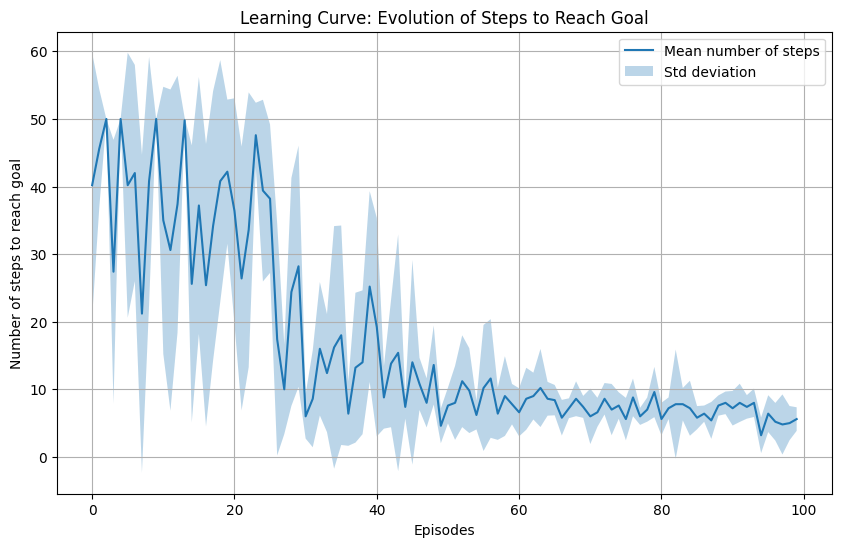

In [53]:
%matplotlib inline
# Run multiple experiments and gather results using parameters from the dictionary
all_trajectories = run_multiple_experiments(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, n_runs)

# Plot the learning curve with mean and standard deviation
plot_learning_curve(all_trajectories)

# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

[I 2024-09-27 19:42:48,123] A new study created in memory with name: no-name-d98163a3-e0b5-48a0-8656-804bb33e31a1
[I 2024-09-27 19:42:48,197] Trial 0 finished with value: 0.016947383046144605 and parameters: {'alpha_actor': 0.028556132720968182, 'alpha_critic': 0.0005178077948864211}. Best is trial 0 with value: 0.016947383046144605.
[I 2024-09-27 19:42:48,247] Trial 1 finished with value: 0.052085647386243716 and parameters: {'alpha_actor': 0.0005403518339253356, 'alpha_critic': 0.0009899277293251543}. Best is trial 0 with value: 0.016947383046144605.
[I 2024-09-27 19:42:48,303] Trial 2 finished with value: 0.11584584912857604 and parameters: {'alpha_actor': 3.9835916941313745e-05, 'alpha_critic': 0.0030692255311263635}. Best is trial 0 with value: 0.016947383046144605.
[I 2024-09-27 19:42:48,365] Trial 3 finished with value: 0.007182030650990022 and parameters: {'alpha_actor': 2.6585217099981754e-05, 'alpha_critic': 0.00018480154781823704}. Best is trial 3 with value: 0.0071820306509

Best Hyperparameters found by Optuna:
{'alpha_actor': 0.7426225672701505, 'alpha_critic': 1.0617760294887959e-05}


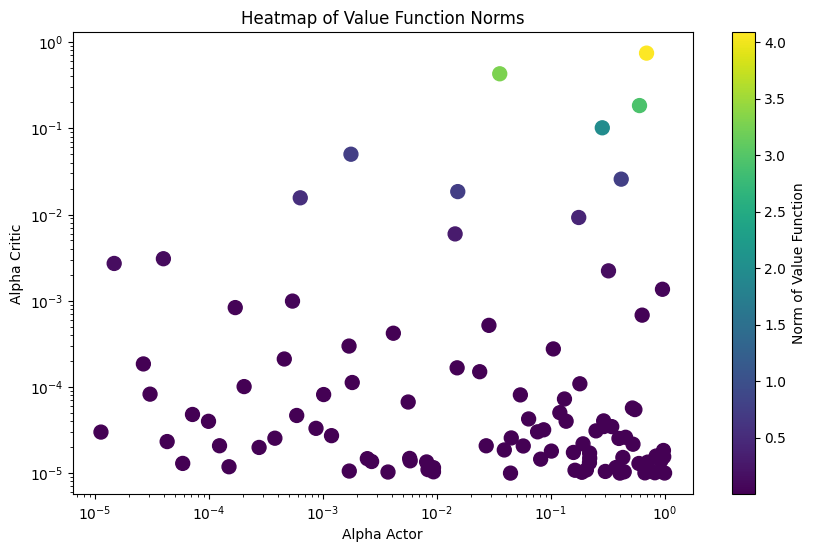

In [54]:
import optuna
import numpy as np
import matplotlib.pyplot as plt

def objective(trial):
    """
    Objective function for Optuna to optimize.
    It runs the actor-critic algorithm and returns the norm of the value function after training.

    Args:
        trial: Optuna trial object to suggest hyperparameters.
    
    Returns:
        The norm of the value function after training.
    """
    # Suggest values for alpha_actor and alpha_critic within a reasonable range
    alpha_actor = trial.suggest_float('alpha_actor', 1e-5, 1.0, log=True)
    alpha_critic = trial.suggest_float('alpha_critic', 1e-5, 1.0, log=True)
    
    # Use default gamma for now
    gamma = 0.99
    
    # Set up the environment and parameters for the actor-critic algorithm
    env = create_maze_from_params(ac_params)  # Use your environment creation function
    nb_episodes = ac_params['nb_episodes']
    timeout = ac_params['timeout']
    
    # Run the naive actor-critic algorithm
    _, V, _ = naive_actor_critic(env, alpha_actor, alpha_critic, gamma, nb_episodes, timeout, render=False)
    
    # Return the norm of the value function as the objective to minimize
    value_norm = np.linalg.norm(V)
    
    return value_norm  # Optuna will minimize this value

def run_bayesian_optimization(n_trials=100):
    """
    Runs Bayesian optimization using Optuna to find the best hyperparameters for actor-critic algorithm.

    Args:
        n_trials: Number of trials to perform for optimization.
    
    Returns:
        study: The Optuna study containing the optimization results.
    """
    # Create a study object using Optuna's default Bayesian sampler
    study = optuna.create_study(direction='minimize')
    
    # Optimize the objective function for a given number of trials
    study.optimize(objective, n_trials=n_trials)
    
    return study

# Example usage: Run Bayesian optimization with 100 trials
study = run_bayesian_optimization(n_trials=100)

# Get the best hyperparameters found by Optuna
best_params = study.best_params
print("Best Hyperparameters found by Optuna:")
print(best_params)

# Step 2: Create a heatmap of the results
def plot_heatmap_from_study(study):
    """
    Plots a heatmap from the study results showing the norm of the value function for different alpha_actor and alpha_critic values.

    Args:
        study: The Optuna study containing the optimization results.
    """
    # Extract the hyperparameters and their corresponding values from the study
    actor_values = []
    critic_values = []
    norm_values = []
    
    for trial in study.trials:
        actor_values.append(trial.params['alpha_actor'])
        critic_values.append(trial.params['alpha_critic'])
        norm_values.append(trial.value)
    
    # Create a scatter plot with a heatmap
    plt.figure(figsize=(10, 6))
    plt.scatter(actor_values, critic_values, c=norm_values, cmap='viridis', s=100)
    plt.colorbar(label='Norm of Value Function')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Alpha Actor')
    plt.ylabel('Alpha Critic')
    plt.title('Heatmap of Value Function Norms')
    plt.show()

# Plot the heatmap of the optimization results
plot_heatmap_from_study(study)

# Collect best hyperparameters for further use
best_alpha_actor = best_params['alpha_actor']
best_alpha_critic = best_params['alpha_critic']


# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [ ]:
from scipy.stats import ttest_ind
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats

In [ ]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [ ]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [ ]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  # 
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended
    
    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [ ]:
# To be completed...

assert False, 'Not implemented yet'


# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.